<a href="https://colab.research.google.com/github/harshit-046/cn/blob/main/cn_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:

import math
import random
import numpy as np
import matplotlib.pyplot as plt

# CONFIGURATION
CONFIG = {
    'area_size': 100.0,
    'num_sensors': 100,
    'num_sinks': 4,
    'initial_energy': 5.0,
    'transmission_range': 20.0,
    'packet_size': 4000,
    'e_elec': 50e-9,
    'e_amp': 1e-12,
    'e_rx': 50e-9,
    'rounds': 300,
    'sink_step': 2.0,
}

# SENSOR NODE CLASS
class SensorNode:
    def __init__(self, node_id, x, y, energy):
        self.id = node_id
        self.x = x
        self.y = y
        self.energy = energy
        self.is_dead = False
        self.neighbors = []
        self.packets_sent = 0

    def update_energy(self, amount):
        self.energy -= amount
        if self.energy <= 0:
            self.is_dead = True
            self.energy = 0

# -----------------------
# MOBILE SINK CLASS
# -----------------------
class MobileSink:
    def __init__(self, id, x, y):
        self.id = id
        self.x = x
        self.y = y
        self.dir = 1

    def move(self):
        self.x += self.dir * CONFIG['sink_step']
        if self.x > 95 or self.x < 5:
            self.dir *= -1

# REEFSM SIMULATOR CORE

class REEFSM_Simulator:
    def __init__(self):
        self.nodes = []
        self.sinks = []
        self.stats = []

    def init_network(self):
        # clustered sensor nodes
        clusters = [(20,20),(20,80),(80,20),(80,80)]
        for i in range(CONFIG['num_sensors']):
            cx, cy = random.choice(clusters)
            x = cx + random.uniform(-15, 15)
            y = cy + random.uniform(-15, 15)
            self.nodes.append(SensorNode(i, x, y, CONFIG['initial_energy']))

        # fixed sink positions
        sink_pos = [(25,25),(25,75),(75,25),(75,75)]
        for i,(x,y) in enumerate(sink_pos):
            self.sinks.append(MobileSink(i, x, y))

    def distance(self,a,b):
        return math.sqrt((a.x - b.x)**2 + (a.y - b.y)**2)

    def neighbor_discovery(self):
        for n in self.nodes:
            n.neighbors = []
        for i,n1 in enumerate(self.nodes):
            if n1.is_dead: continue
            for j,n2 in enumerate(self.nodes):
                if i!=j and not n2.is_dead:
                    if self.distance(n1,n2)<=CONFIG['transmission_range']:
                        n1.neighbors.append(j)

    def tx_energy(self,d):
        return CONFIG['e_elec']*CONFIG['packet_size'] + CONFIG['e_amp']*CONFIG['packet_size']*d*d

    def rx_energy(self):
        return CONFIG['e_rx']*CONFIG['packet_size']

    def run_round(self,r):
        packets_sent=0
        packets_recv=0
        dead_nodes=0

        # move sinks
        for s in self.sinks:
            s.move()

        for node in self.nodes:
            if node.is_dead:
                dead_nodes+=1
                continue

            # choose nearest sink
            nearest_sink=min(self.sinks,key=lambda s: self.distance(node,s))
            d=self.distance(node,nearest_sink)

            # direct transmission possible?
            if d<=CONFIG['transmission_range']:
                E=self.tx_energy(d)
                if node.energy>=E:
                    node.update_energy(E)
                    packets_sent+=1
                    packets_recv+=1
                    node.packets_sent+=1
                else:
                    node.update_energy(node.energy) # die
                continue

            # multi-hop: choose best neighbor
            best=None; best_d=999
            for nid in node.neighbors:
                nb=self.nodes[nid]
                if nb.is_dead: continue
                d_nb=self.distance(nb,nearest_sink)
                if d_nb<best_d:
                    best=nb; best_d=d_nb

            # perform multi-hop
            if best:
                E_node = self.tx_energy(self.distance(node,best))
                E_best_rx = self.rx_energy()
                E_best_tx = self.tx_energy(best_d)
                if node.energy>=E_node and best.energy>=E_best_rx+E_best_tx:
                    node.update_energy(E_node)
                    best.update_energy(E_best_rx+E_best_tx)
                    packets_sent+=1
                    packets_recv+=1
                    node.packets_sent+=1

        self.stats.append({
            "round": r,
            "alive": CONFIG['num_sensors'] - sum(n.is_dead for n in self.nodes),
            "energy": sum(n.energy for n in self.nodes),
            "pdr": packets_recv/max(1,packets_sent),
            "dead": sum(n.is_dead for n in self.nodes)
        })

    def run(self):
        self.init_network()
        self.neighbor_discovery()
        for r in range(1,CONFIG['rounds']+1):
            self.run_round(r)

sim = REEFSM_Simulator()
sim.run()
print("Simulation Complete!")


Simulation Complete!


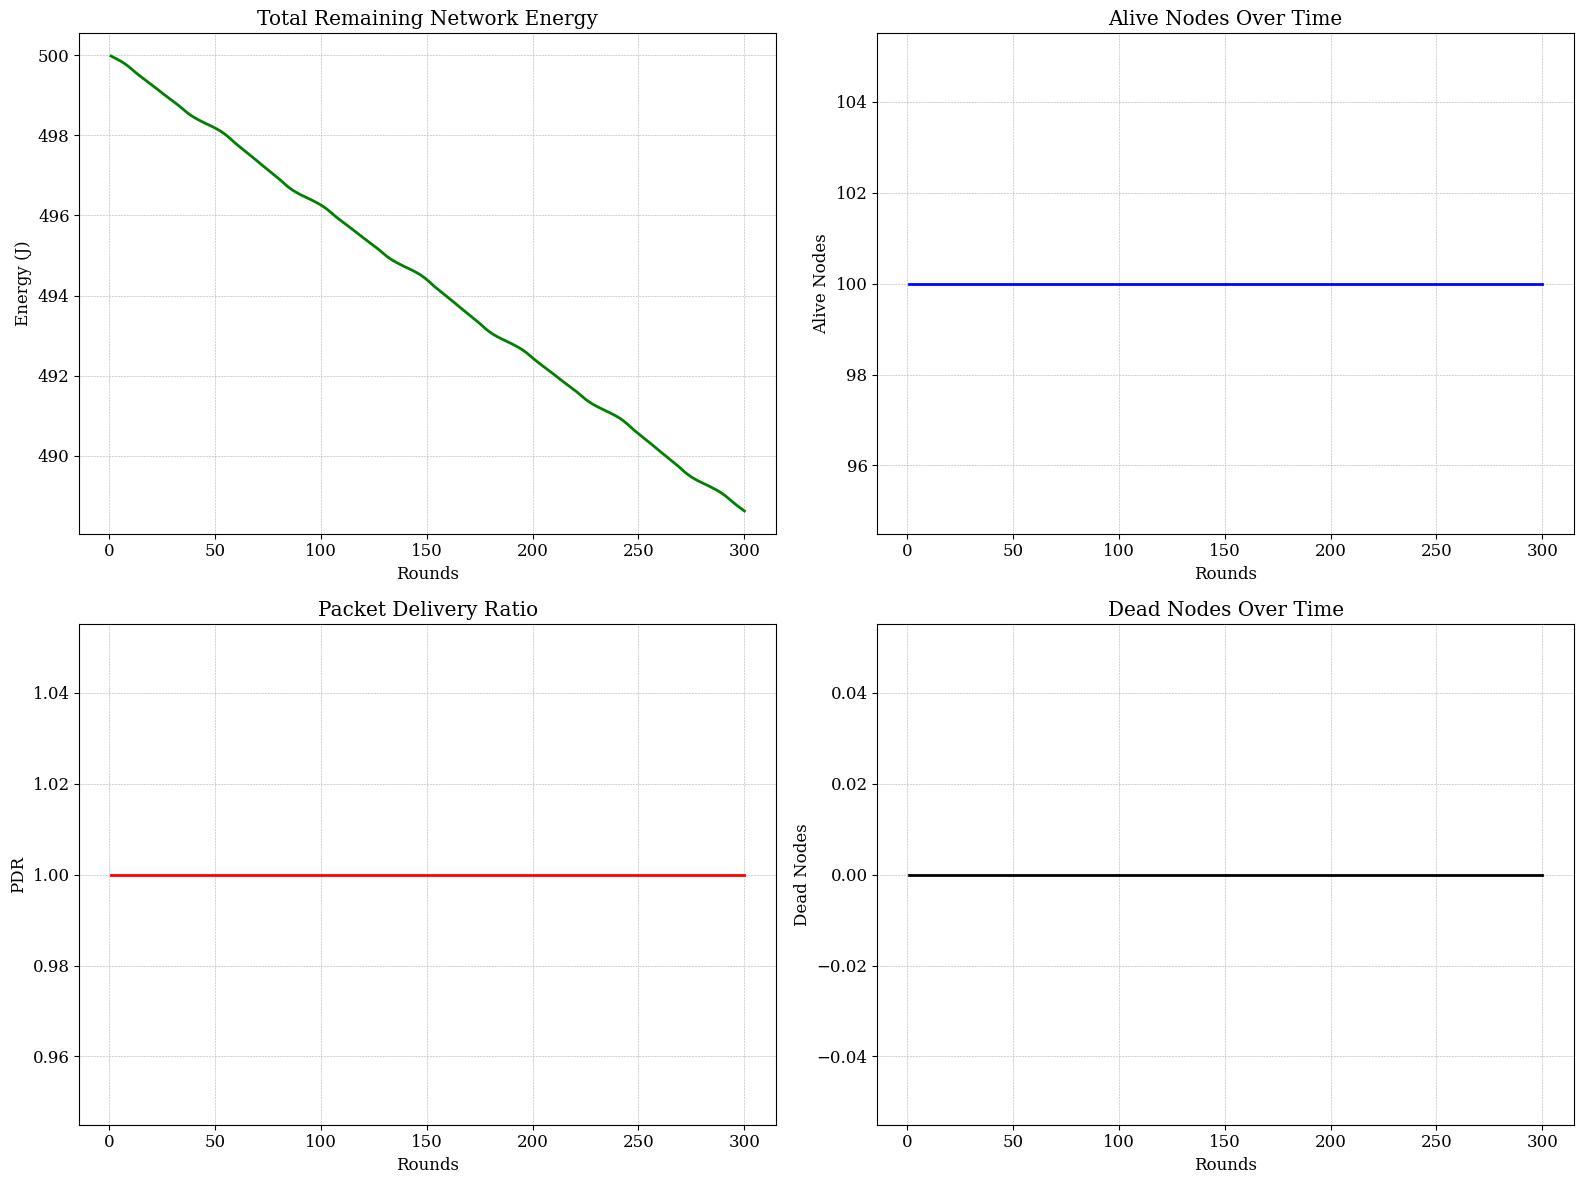

In [5]:
# PLOTS FOR RESEARCH PAPER
import matplotlib.pyplot as plt

rounds=[s["round"] for s in sim.stats]
energy=[s["energy"] for s in sim.stats]
alive=[s["alive"] for s in sim.stats]
pdr=[s["pdr"] for s in sim.stats]
dead=[s["dead"] for s in sim.stats]

plt.figure(figsize=(16,12))

# Total Energy
plt.subplot(2,2,1)
plt.plot(rounds,energy,'g',linewidth=2)
plt.title("Total Remaining Network Energy")
plt.xlabel("Rounds"); plt.ylabel("Energy (J)")
plt.grid(True)

# Alive Nodes
plt.subplot(2,2,2)
plt.plot(rounds,alive,'b',linewidth=2)
plt.title("Alive Nodes Over Time")
plt.xlabel("Rounds"); plt.ylabel("Alive Nodes")
plt.grid(True)

# Packet Delivery Ratio (PDR)
plt.subplot(2,2,3)
plt.plot(rounds,pdr,'r',linewidth=2)
plt.title("Packet Delivery Ratio")
plt.xlabel("Rounds"); plt.ylabel("PDR")
plt.grid(True)

# Dead nodes
plt.subplot(2,2,4)
plt.plot(rounds,dead,'k',linewidth=2)
plt.title("Dead Nodes Over Time")
plt.xlabel("Rounds"); plt.ylabel("Dead Nodes")
plt.grid(True)

plt.tight_layout()
plt.show()


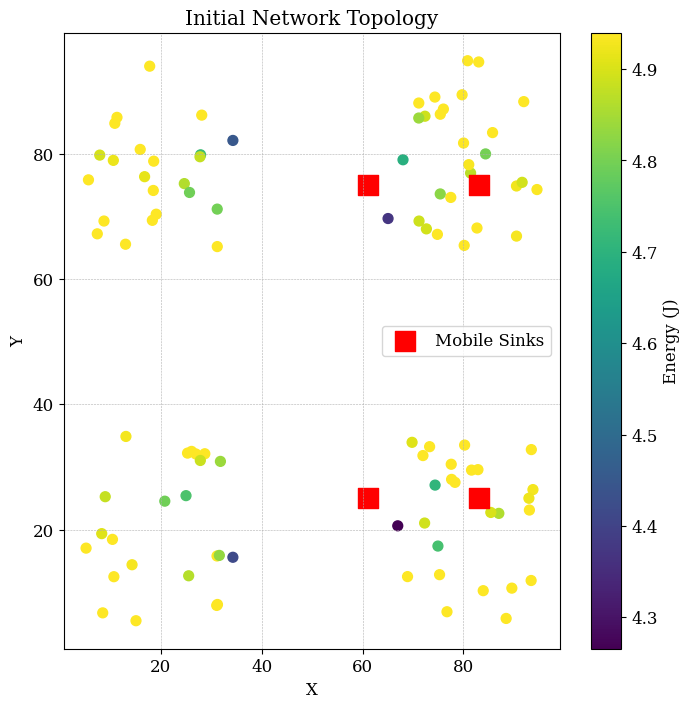

In [6]:
plt.figure(figsize=(8,8))

xs=[n.x for n in sim.nodes]
ys=[n.y for n in sim.nodes]
energies=[n.energy for n in sim.nodes]

plt.scatter(xs,ys,c=energies,cmap='viridis',s=50)
plt.colorbar(label="Energy (J)")

# sinks
sx=[s.x for s in sim.sinks]
sy=[s.y for s in sim.sinks]
plt.scatter(sx,sy,c="red",marker="s",s=200,label="Mobile Sinks")

plt.title("Initial Network Topology")
plt.xlabel("X"); plt.ylabel("Y")
plt.grid(True)
plt.legend()
plt.show()
